<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Problem Statement

As a data scientist hired by a coffee and tea company to leverage data to provide some insights, this project uses NLP to help train a classifier on whether a post came from the coffee subreddit or tea subreddit.  By deploying the push shift API in a manner where we can automate a vast web scrape we can get a substantial amount of posts for the purpose of this project.  We will compare the respective performances of different classification models. We can gauge success by comparing it to a baseline model and whether the model exceeds this.  The stakeholders at the coffee and tea company would be interested to see what words or combination of words are of most use. This study may be of interest to numerous people as coffee and tea are two of the three most popular beverages in the world (alongside water) and two of the most profitable international commodities.  While not all coffee and teas are caffeinated, many throughout the globe who enjoy these beverages attribute their popularity to the invigorating effect produced by caffeine(Myhrvoid, N., 2021). 

References:

https://www.britannica.com/topic/coffee<br>
https://www.britannica.com/topic/tea-beverage<br>
https://www.pbs.org/food/the-history-kitchen/history-coffee/

## Datasets Collection

Dataset was obtained by using the pushshift api function in order to webscrape reddit and specifically the following two subreddits:coffee & tea. Each of these sets will include the following columns, the posts and the subreddit name it came from.  
- [`coffee.csv`](../data/coffee.csv): Coffee subreddit posts 
- [`tea.csv`](../data/tea.csv): Tea subreddit posts

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|post|*object*|coffee/tea|A post within a subreddit|
|subreddit|*object*|coffee/tea|Subreddit by category|
|post_len|*int*|coffee/tea|Length of a post|
|word_count|*int*|coffee/tea|The word count within a post|


### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import urllib
import time
import json

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score

### Exploratory Data Analysis

In [2]:
coffee = pd.read_csv('../data/coffee.csv')
tea= pd.read_csv('../data/tea.csv')

In [3]:
tea['subreddit']='Tea'

In [4]:
coffee.head()

,id,date,post,score,subreddit
0,refhkl,1639278068,"Voici un livre incroyable, qui vous fera gagne...",1,Coffee
1,refe3x,1639277766,Hey all o/\n\nMy wife is amazing at making cof...,1,Coffee
2,ree76q,1639273771,So I've recently just started making my own co...,1,Coffee
3,redlcc,1639271750,"Hello all!\n\nI have been doing some research,...",1,Coffee
4,red1px,1639270007,I’ve gotten pretty comfortable switching betwe...,1,Coffee


In [5]:
tea.head()

,Unnamed: 0,id,date,post,score,subreddit
0,1,rdmw13,1639182291,hi im 17 and just broke up with my frist girl...,1,Tea
1,5,rdkm3p,1639175699,I'm wanting to buy a Gaiwan to start trying mo...,1,Tea
2,6,rdjrnq,1639173432,I do not enjoy drinking my tea out of metal cu...,1,Tea
3,8,rdhek3,1639167086,They now sell a couple of hei cha's including ...,1,Tea
4,15,rdc6gx,1639153097,"Shortly after drinking it I get very drowsy, n...",1,Tea


In [6]:
coffee.shape, tea.shape

((15162, 5), (11879, 6))

In [7]:
coffee.isnull().sum()

id            0
date          0
post         96
score         0
subreddit     0
dtype: int64

In [8]:
tea.isnull().sum()

Unnamed: 0     0
id             0
date           0
post          21
score          0
subreddit      0
dtype: int64

In [9]:
coffee.dropna(inplace=True)
tea.dropna(inplace=True)
#get rid of rows with nulls

In [10]:
coffee.shape, tea.shape

((15066, 5), (11858, 6))

In [11]:
coffee=coffee.drop(coffee.index[-3208:])
coffee.shape
#https://www.kite.com/python/answers/how-to-get-the-last-n-rows-from-a-pandas-dataframe-in-python
#got rid of necessary amount of coffee rows in order to get equal posts.

(11858, 5)

In [12]:
tea.head()

,Unnamed: 0,id,date,post,score,subreddit
0,1,rdmw13,1639182291,hi im 17 and just broke up with my frist girl...,1,Tea
1,5,rdkm3p,1639175699,I'm wanting to buy a Gaiwan to start trying mo...,1,Tea
2,6,rdjrnq,1639173432,I do not enjoy drinking my tea out of metal cu...,1,Tea
3,8,rdhek3,1639167086,They now sell a couple of hei cha's including ...,1,Tea
4,15,rdc6gx,1639153097,"Shortly after drinking it I get very drowsy, n...",1,Tea


In [13]:
removed_coffee_drop=coffee[coffee['post']=='[removed]'].index
coffee.drop(removed_coffee_drop,inplace=True)

deleted_coffee_drop=coffee[coffee['post']=='[deleted]'].index
coffee.drop(deleted_coffee_drop,inplace=True)
#quiz 2 retake
#dropped [removed] posts as they are the equivalent of nulls

In [14]:
removed_tea_drop=tea[tea['post']=='[removed]'].index
tea.drop(removed_tea_drop,inplace=True)

deleted_tea_drop=tea[tea['post']=='[deleted]'].index
tea.drop(deleted_tea_drop,inplace=True)
#quiz 2 retake
#dropped [removed] posts as they are the equivalent of nulls

In [15]:
coffee.shape, tea.shape

((10706, 5), (9796, 6))

In [16]:
coffee.head(1)

,id,date,post,score,subreddit
0,refhkl,1639278068,"Voici un livre incroyable, qui vous fera gagne...",1,Coffee


In [17]:
tea.head(1)

,Unnamed: 0,id,date,post,score,subreddit
0,1,rdmw13,1639182291,hi im 17 and just broke up with my frist girl...,1,Tea


In [18]:
coffee=coffee.drop(coffee.index[-910:])
coffee.shape, tea.shape

((9796, 5), (9796, 6))

In [19]:
tea.to_csv('../data/tea_engineered.csv',index=False)

In [20]:
coffee.to_csv('../data/coffee_engineered.csv',index=False)

In [21]:
cv=CountVectorizer()
coffee_vect=cv.fit_transform(coffee['post'])
coffee_vect_df=pd.DataFrame(coffee_vect.todense(), columns=cv.get_feature_names())
coffee_vect_df.head()

,00,000,0004850020184,0005012_illy,000ish,000mg,000s,0013631_saeco,0023549b97b6d8b33449230513c44eda6341dca4,0042,...,школы,этапа,этапе,это,этой,этом,𝐀𝐧𝐭𝐢,𝐁𝐫𝐢𝐠𝐡𝐭𝐞𝐧𝐢𝐧𝐠,𝐚𝐠𝐢𝐧𝐠,𝐬𝐞𝐫𝐢𝐞𝐬
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
tea_vect=cv.fit_transform(tea['post'])
tea_vect_df = pd.DataFrame(tea_vect.todense(), columns=cv.get_feature_names())
tea_vect_df.head()

,00,000,0006,000ft,000pcs,002,00291,003,00373207,0041003,...,나왔다는,둥글래,문화가,신선차,아아,영국의,이것은마치,이야기,중국의,차문화에서
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


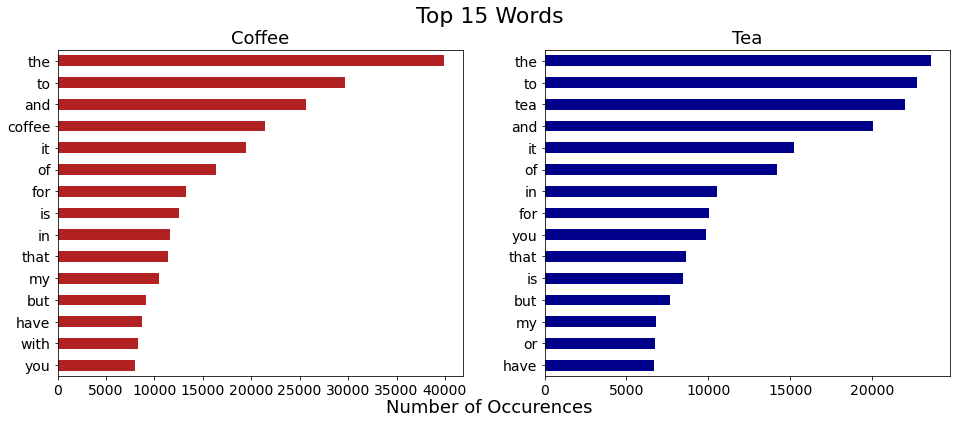

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
coffee_vect_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], fontsize=14, color = 'firebrick')
tea_vect_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[1], fontsize=14, color = 'darkblue')

ax[0].set_title('Coffee', fontsize=18)
ax[1].set_title('Tea', fontsize=18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 15 Words', fontsize=22)
fig.text(0.5, 0.04, 'Number of Occurences', 
         ha='center', fontsize=18);
plt.savefig('../images/top15words.png')
#week 7 breakfast hour

We can see that words like "the", "to","and","it round out most of the top five.  We can see it diverges with the words coffee and tea respectively, which makes sense as they are the subject matter in the subreddits. 

In [24]:
cvw=CountVectorizer(stop_words='english', ngram_range=(2,2))

tea_vect2=cvw.fit_transform(tea['post'])
tea_vect2_df = pd.DataFrame(tea_vect2.todense(), columns=cvw.get_feature_names())

coffee_vect2=cvw.fit_transform(coffee['post'])
coffee_vect2_df=pd.DataFrame(coffee_vect2.todense(), columns=cvw.get_feature_names())
#week 7 breakfast hour

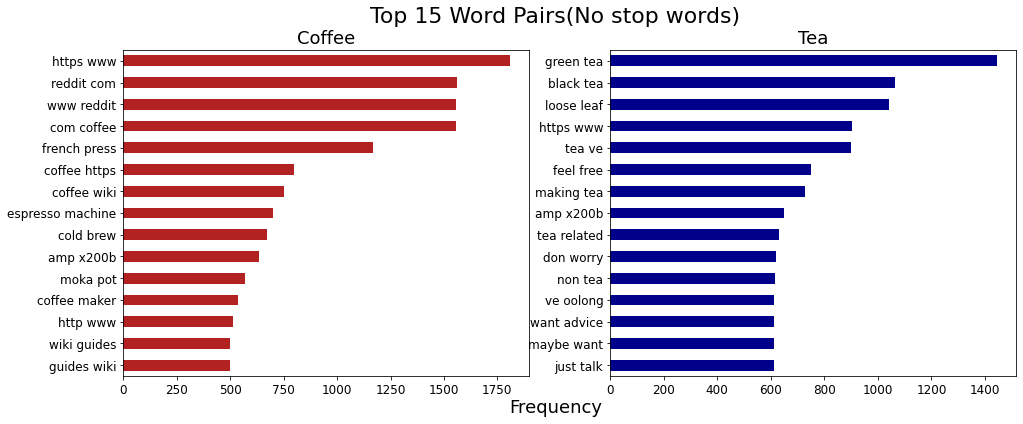

In [25]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
coffee_vect2_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0],
                                                                fontsize=12, color='firebrick')
tea_vect2_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[1],
                                                             fontsize=12, color = 'darkblue')

ax[0].set_title('Coffee', fontsize= 18)
ax[1].set_title('Tea', fontsize =18)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle('Top 15 Word Pairs(No stop words)', fontsize=22)
fig.text(.5,.04, 'Frequency', ha='center', fontsize=18);
plt.savefig('../images/top15wordpairs_nosw.png')
#week 7 breakfast hour

When we filter out the stop words and add a bit more context by looking at word pairings, we can see that in the coffee subreddit there is a strong presence with brewing methods such as "french press, espresso machine, cold brew, moka pot and coffee maker".  Whereas in the tea subreddit its more about the product itself "green tea, black tea, loose leaf, ve oolong".  

In [26]:
coffee['post_len'] = coffee['post'].apply(len)
tea['post_len']=tea['post'].apply(len)
#week 7 breakfast hour

In [27]:
coffee['word_count']=coffee['post'].apply(lambda x:len(x.split()))
tea['word_count']=tea['post'].apply(lambda x:len(x.split()))
#week 7 breakfast hour

In [28]:
coffee.head(1)

,id,date,post,score,subreddit,post_len,word_count
0,refhkl,1639278068,"Voici un livre incroyable, qui vous fera gagne...",1,Coffee,648,45


In [29]:
tea.head(1)

,Unnamed: 0,id,date,post,score,subreddit,post_len,word_count
0,1,rdmw13,1639182291,hi im 17 and just broke up with my frist girl...,1,Tea,103,22


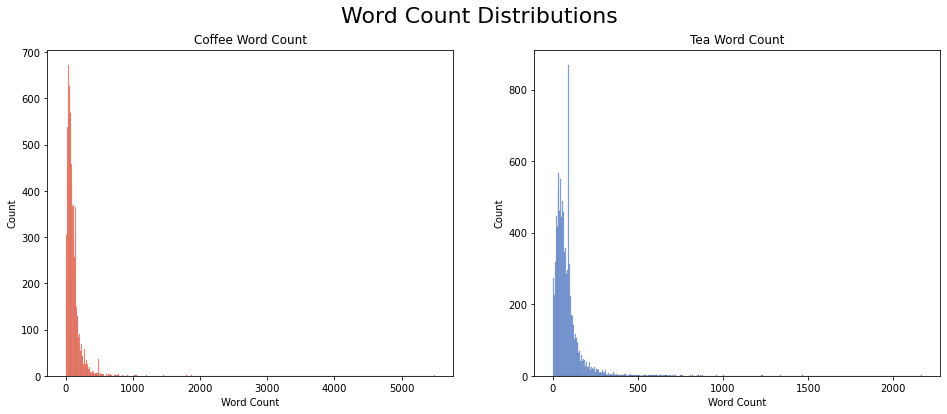

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(coffee['word_count'], ax=ax[0], color ='tomato')
sns.histplot(tea['word_count'], ax=ax[1], color = 'cornflowerblue')
ax[0].set(xlabel="Word Count", ylabel='Count', title='Coffee Word Count')
ax[1].set(xlabel="Word Count", ylabel='Count', title='Tea Word Count')

fig.suptitle('Word Count Distributions', fontsize=22);
plt.savefig('../images/wordcountdistributions.png')

When comparing the word count distributions for each subreddit, you can see two examples of extremely right-skewed distributions.  People tend to write less than 500 word messages on both subreddits. 

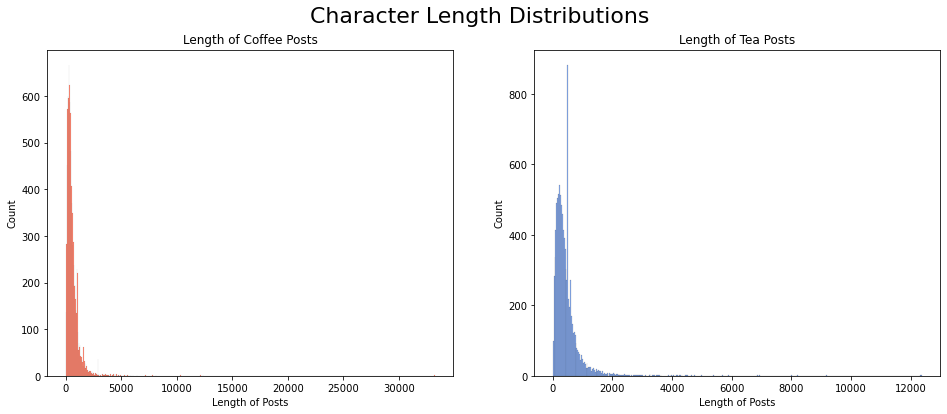

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.histplot(coffee['post_len'], ax=ax[0], color ='tomato')
sns.histplot(tea['post_len'], ax=ax[1], color = 'cornflowerblue')
ax[0].set(xlabel="Length of Posts", ylabel='Count', title='Length of Coffee Posts')
ax[1].set(xlabel="Length of Posts", ylabel='Count', title='Length of Tea Posts')

fig.suptitle('Character Length Distributions', fontsize=22);
plt.savefig('../images/len_of_char_hists.png')

The distributions for length of each posts closely shadows the word count distribution. Length of posts look to be slightly higher in the coffee subreddit(Coffee median of 439 over tea median 356).

In [32]:
coffee.describe()

,date,score,post_len,word_count
count,9.796000e+03,9796.000000,9796.000000,9796.000000
mean,1.628382e+09,1.236117,597.591670,105.990710
std,6.452383e+06,5.530839,678.918726,115.727035
min,1.617322e+09,0.000000,1.000000,1.000000
25%,1.622552e+09,1.000000,258.750000,47.000000
50%,1.628398e+09,1.000000,439.000000,80.000000
75%,1.634139e+09,1.000000,744.000000,135.000000
max,1.639278e+09,389.000000,33220.000000,5492.000000


In [33]:
tea.describe()

,Unnamed: 0,date,score,post_len,word_count
count,9796.000000,9.796000e+03,9796.000000,9796.000000,9796.000000
mean,49.985300,1.609409e+09,1.250000,456.465904,82.101368
std,28.658949,1.725024e+07,2.132199,491.751185,85.971668
min,0.000000,1.577825e+09,0.000000,1.000000,1.000000
25%,25.000000,1.595343e+09,1.000000,204.750000,37.000000
50%,50.000000,1.609319e+09,1.000000,356.000000,65.000000
75%,75.000000,1.624056e+09,1.000000,533.000000,97.000000
max,99.000000,1.639182e+09,130.000000,12367.000000,2166.000000


In [34]:
coffee_tea=pd.concat([coffee,tea], axis=0)
coffee_tea.shape
#https://www.geeksforgeeks.org/merge-two-dataframes-with-same-column-names/
#concatenated both subreddit posts df

(19592, 8)

In [35]:
coffee_tea.to_csv('../data/coffee_tea.csv',index=False)


In [36]:
coffee_tea.head()

,id,date,post,score,subreddit,post_len,word_count,Unnamed: 0
0,refhkl,1639278068,"Voici un livre incroyable, qui vous fera gagne...",1,Coffee,648,45,NaN
1,refe3x,1639277766,Hey all o/\n\nMy wife is amazing at making cof...,1,Coffee,1332,243,NaN
2,ree76q,1639273771,So I've recently just started making my own co...,1,Coffee,228,40,NaN
3,redlcc,1639271750,"Hello all!\n\nI have been doing some research,...",1,Coffee,655,119,NaN
4,red1px,1639270007,I’ve gotten pretty comfortable switching betwe...,1,Coffee,598,108,NaN


In [37]:
coffee_tea.drop(columns=['date','Unnamed: 0','id','score'],inplace=True)
coffee_tea
#drop columns for just posts and subreddit.

,post,subreddit,post_len,word_count
0,"Voici un livre incroyable, qui vous fera gagne...",Coffee,648,45
1,Hey all o/\n\nMy wife is amazing at making cof...,Coffee,1332,243
2,So I've recently just started making my own co...,Coffee,228,40
3,"Hello all!\n\nI have been doing some research,...",Coffee,655,119
4,I’ve gotten pretty comfortable switching betwe...,Coffee,598,108
...,...,...,...,...
11874,After reading a lot of posts here I bought som...,Tea,281,52
11875,Anybody have any water boilers that can monito...,Tea,161,29
11876,"Hi all. I'm a huge coffee, green tea and black...",Tea,493,89
11877,My fiance keeps making fun of me and calling m...,Tea,203,40


In [38]:
coffee_tea.to_csv('../data/coffee_tea.csv',index=False)

In [39]:
coffee_tea['subreddit'].value_counts(normalize=True)

Tea       0.5
Coffee    0.5
Name: subreddit, dtype: float64

In [40]:
coffee_tea

,post,subreddit,post_len,word_count
0,"Voici un livre incroyable, qui vous fera gagne...",Coffee,648,45
1,Hey all o/\n\nMy wife is amazing at making cof...,Coffee,1332,243
2,So I've recently just started making my own co...,Coffee,228,40
3,"Hello all!\n\nI have been doing some research,...",Coffee,655,119
4,I’ve gotten pretty comfortable switching betwe...,Coffee,598,108
...,...,...,...,...
11874,After reading a lot of posts here I bought som...,Tea,281,52
11875,Anybody have any water boilers that can monito...,Tea,161,29
11876,"Hi all. I'm a huge coffee, green tea and black...",Tea,493,89
11877,My fiance keeps making fun of me and calling m...,Tea,203,40


### EDA on Posts

In [41]:
coffee_tea.describe()

,post_len,word_count
count,19592.000000,19592.000000
mean,527.028787,94.046039
std,596.939168,102.635711
min,1.000000,1.000000
25%,227.000000,41.000000
50%,396.000000,72.000000
75%,629.000000,114.000000
max,33220.000000,5492.000000


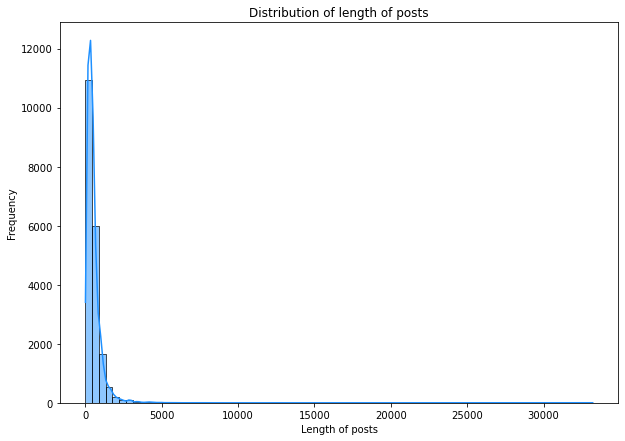

In [42]:
plt.figure(figsize=(10,7))
plt.title('Distribution of length of posts')
plt.xlabel('Length of posts')
plt.ylabel('Frequency')
sns.histplot(data=coffee_tea, x=coffee_tea['post_len'],kde=True, bins=75,color='dodgerblue');
plt.savefig('../images/dist_of_post_length(total).png')

The combined subreddit length of posts follows the same skewedness as each subreddit individually.

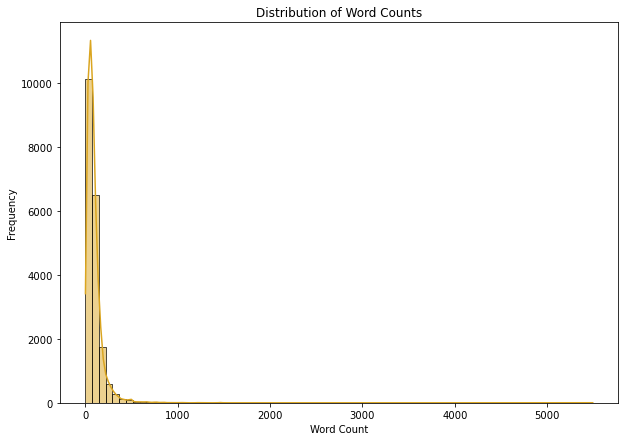

In [43]:
plt.figure(figsize=(10,7))
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
sns.histplot(data=coffee_tea, x=coffee_tea['word_count'],kde=True, bins=75,color='goldenrod');
plt.savefig('../images/dist_of_word_count(total).png')

The same goes for the total word count 

### EDA with CountVectorize

In [44]:
X=coffee_tea['post']
y=coffee_tea['subreddit']

X_train, X_test, y_train, y_test=train_test_split(X,y, 
                                                 test_size=.30,
                                                 random_state=42,
                                                 stratify=y)

In [45]:
cvec=CountVectorizer()

cvec.fit(X_train)

X_train=cvec.transform(X_train)

In [46]:
X_train

<13714x29141 sparse matrix of type '<class 'numpy.int64'>'
	with 848368 stored elements in Compressed Sparse Row format>

In [47]:
cvec.get_feature_names()[1000:1010]

['250mg',
 '250ml',
 '250ppm',
 '251',
 '25257c00365',
 '25257c01',
 '25257cp77',
 '25257csh',
 '25257ct02',
 '25257cv04_kasa_ppc']

In [48]:
X_train.shape

(13714, 29141)

In [49]:
X_test=cvec.transform(X_test)

In [50]:
X_train_df=pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names())
X_train_df

,00,000,0004850020184,0005012_illy,000ft,000ish,000mg,000pcs,000s,0013631_saeco,...,超福金,通天香,나왔다는,문화가,아아,영국의,이것은마치,이야기,중국의,차문화에서
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


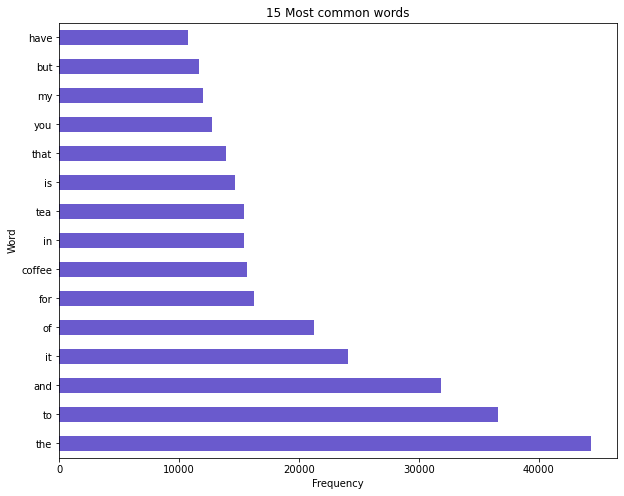

In [51]:
plt.figure(figsize=(10,8))
plt.title('15 Most common words')
plt.xlabel('Frequency')
plt.ylabel('Word')
X_train_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', color='slateblue');

These are the 15 most common words across both subreddits.  This includes stop words as well as coffee and tea(the subject matter themselves). 

In [52]:
X=coffee_tea['post']
y=coffee_tea['subreddit']

X_train, X_test, y_train, y_test=train_test_split(X,y, 
                                                 test_size=.30,
                                                 random_state=42,
                                                 stratify=y)

In [53]:
cvec2=CountVectorizer(stop_words='english')


cvec2.fit(X_train)

X_train=cvec2.transform(X_train)

X_test=cvec2.transform(X_test)

X_tr_stop_df=pd.DataFrame(X_train.todense(), columns=cvec2.get_feature_names())
X_tr_stop_df

,00,000,0004850020184,0005012_illy,000ft,000ish,000mg,000pcs,000s,0013631_saeco,...,超福金,通天香,나왔다는,문화가,아아,영국의,이것은마치,이야기,중국의,차문화에서
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


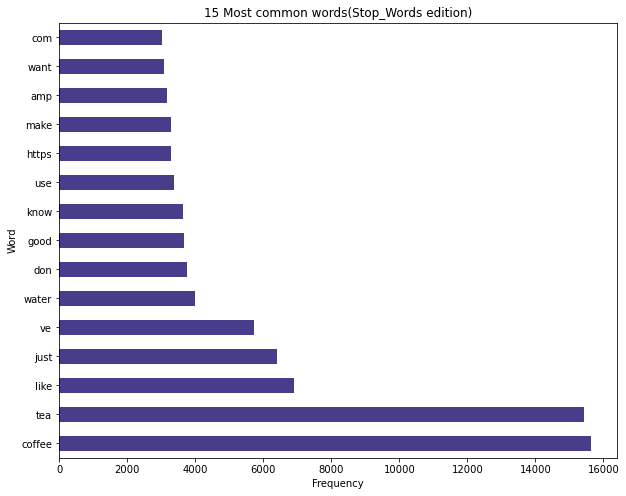

In [54]:
plt.figure(figsize=(10,8))
plt.title('15 Most common words(Stop_Words edition)')
plt.xlabel('Frequency')
plt.ylabel('Word')
X_tr_stop_df.sum().sort_values(ascending=False).head(15).plot(kind='barh',color='darkslateblue');

When you count vectorize and strip away the stop words, you get: coffee, tea, like, just, ve, and water rounding out the most frequently used words. 

## Evaluating the models

We will evaluate this classification problem from the lens of accuracy, recall, specificity, Type I and Type II.  Recall allows you to know when you correctly predicted the cases in the true class. The true class in this case is the tea subreddit. Specificity lets you find out how well you can predict the negative class, which is the coffee subreddit. Finally with Type I & Type II errors you can see the percentage at which your model incorrectly predicts these classes respectively. 

References:<br>
https://towardsdatascience.com/the-3-most-important-basic-classification-metrics-3368dd425f74<br>
https://towardsdatascience.com/the-3-most-important-composite-classification-metrics-b1f2d886dc7b

## Classifying Models

### Baseline

In [121]:
coffee_tea['subreddit'].value_counts(normalize=True)

Tea       0.5
Coffee    0.5
Name: subreddit, dtype: float64

### Multinomial NB Model

In [55]:
X=coffee_tea['post']
y=coffee_tea['subreddit']

X_train, X_test, y_train, y_test=train_test_split(X,y, 
                                                 test_size=.30,
                                                 random_state=42,
                                                 stratify=y)

In [56]:
pipe_nb= Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [57]:
pipenb_params= {
    'cvec__max_features':[2000,3000,4000],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.9],
    'cvec__ngram_range':[(1,1),(1,2)]
}

In [58]:
gs_nb=GridSearchCV(pipe_nb,
                  param_grid=pipenb_params,
                   cv=5,
                   n_jobs=4)

In [59]:
gs_nb.fit(X_train, y_train)

/opt/anaconda3/envs/dsi-111/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [60]:
print(gs_nb.best_score_)

0.9564675602880671


In [61]:
gs_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [62]:
gs_nb.score(X_train,y_train)

0.961061688785183

In [63]:
gs_nb.score(X_test, y_test)

0.95831915617557

1-accuracy=misclassification rate


In [64]:
f'Misclassification rate is: {1-0.955946303649083}'

'Misclassification rate is: 0.04405369635091705'

In [65]:
nb_preds=gs_nb.predict(X_test)

In [66]:
tn,fp,fn,tp=confusion_matrix(y_test,nb_preds).ravel()

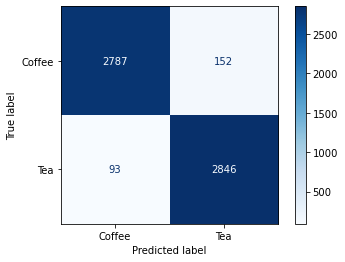

In [67]:
plot_confusion_matrix(gs_nb, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig('../images/nb_confusion_matrix.png')

In [68]:
print(tn,fp,fn,tp)

2787 152 93 2846


In [69]:
spec=tn/(tn+fp)

print(f'Specificity: {spec}')

Specificity: 0.9482817284790745


This model correctly predicted 94.8% of the posts in the coffee subreddit.

In [70]:
recall=tp/(tp+fn)
print(f'Sensitivity(recall) is : {recall}')


Sensitivity(recall) is : 0.9683565838720654


Our model correctly predicted 96.8% of the posts in the tea subreddit.

In [71]:
prec=tp/(tp+fp)
print(f'Precision: {prec}')

Precision: 0.9492995330220146


In [72]:
f1=2*(prec*recall)/(prec+recall)
print(f'F1 is : {f1}')
#https://towardsdatascience.com/the-3-most-important-composite-classification-metrics-b1f2d886dc7b

F1 is : 0.9587333670203806


In [73]:
type_I=1-spec
print(f'Type I error is: {type_I}')

Type I error is: 0.05171827152092545


Our model incorrectly predicted 5.2% of the posts belonging to the coffee subreddit.

In [74]:
type_II=1-recall
print(f'Type II error is: {type_II}')

Type II error is: 0.03164341612793464


Our model incorrectly predicted 3.2 % of the posts in the tea subreddit.

### Multinomial NB/CountVectorizer(with stopwords) Model

In [75]:
X=coffee_tea['post']
y=coffee_tea['subreddit']

X_train2, X_test2, y_train2, y_test2=train_test_split(X,y, 
                                                 test_size=.30,
                                                 random_state=42,
                                                 stratify=y)

In [76]:
pipe_nb2=Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [77]:
pipenb2_params= {
    'cvec__max_features':[2000,3000,4000],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.9],
    'cvec__ngram_range':[(1,1),(1,2)]
}

In [78]:
gs_nb2=GridSearchCV(pipe_nb2,
                  param_grid=pipenb2_params,
                   cv=5,
                   n_jobs=4)

In [79]:
gs_nb2.fit(X_train2, y_train2)

/opt/anaconda3/envs/dsi-111/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [80]:
print(gs_nb2.best_score_)

0.9604050147673823


In [81]:
gs_nb2.score(X_train2,y_train2)

0.9642700889601866

In [82]:
gs_nb2.score(X_test2,y_test2)

0.9630826811840763

In [83]:
gs_nb2.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [84]:
f'Misclassification rate is {1-gs_nb2.score(X_train2,y_train2)}'

'Misclassificaiton rate is 0.03572991103981338'

In [85]:
nb2_preds=gs_nb2.predict(X_test2)

tn,fp,fn,tp= confusion_matrix(y_test2,nb2_preds).ravel()

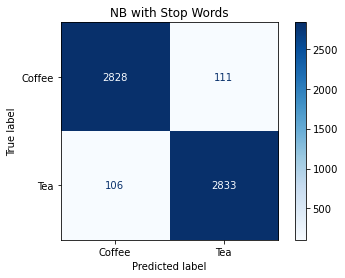

In [86]:
plot_confusion_matrix(gs_nb2, X_test2, y_test2, cmap='Blues', values_format='d');
plt.title('NB with Stop Words');
plt.savefig('../images/nbsw_confusion_matrix.png')

In [87]:
print(tn,fp,fn,tp)

2828 111 106 2833


In [88]:
spec= tn/(tn+fp)

print(f'Specificity is : {spec}')

Specificity is : 0.9622320517182715


Among those in the coffee subreddit post 95.4% were predicted correctly via this model.

In [89]:
recall=tp/(tp+fn)
print(f'Sensitivity(recall) is : {recall}')

Sensitivity(recall) is : 0.9639333106498809


This model correctly predicted 96.4% of the posts belonging in the tea subreddit.

In [90]:
precision=tp/(tp+fp)

print(f'Precision: {precision}')

Precision: 0.962296195652174


In [91]:
f1=2*(prec*recall)/(prec+recall)
print(f'F1 is : {f1}')
#https://towardsdatascience.com/the-3-most-important-composite-classification-metrics-b1f2d886dc7b

F1 is : 0.9565604570200682


In [92]:
type_I=1-spec
print(f'Type I error is: {type_I}')

Type I error is: 0.03776794828172847


The model incorrectly predicted 3.8% of the posts in the coffee subreddit.

In [93]:
type_II=1-recall
print(f'Type II error is: {type_II}')

Type II error is: 0.03606668935011914


The model incorrectly predicted 3.6% of the posts belonging to tea subreddit.

### RandomForestClassification(Pipeline & Gridsearch)

In [94]:
X_train3,X_test3,y_train3,y_test3= train_test_split(X,y,
                                                   random_state=42,
                                                   stratify=y)

piperf= Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('rfc', RandomForestClassifier()),
])


In [95]:
piperf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cv', 'rfc', 'cv__analyzer', 'cv__binary', 'cv__decode_error', 'cv__dtype', 'cv__encoding', 'cv__input', 'cv__lowercase', 'cv__max_df', 'cv__max_features', 'cv__min_df', 'cv__ngram_range', 'cv__preprocessor', 'cv__stop_words', 'cv__strip_accents', 'cv__token_pattern', 'cv__tokenizer', 'cv__vocabulary', 'rfc__bootstrap', 'rfc__ccp_alpha', 'rfc__class_weight', 'rfc__criterion', 'rfc__max_depth', 'rfc__max_features', 'rfc__max_leaf_nodes', 'rfc__max_samples', 'rfc__min_impurity_decrease', 'rfc__min_impurity_split', 'rfc__min_samples_leaf', 'rfc__min_samples_split', 'rfc__min_weight_fraction_leaf', 'rfc__n_estimators', 'rfc__n_jobs', 'rfc__oob_score', 'rfc__random_state', 'rfc__verbose', 'rfc__warm_start'])

In [96]:
rf_params={
    'rfc__n_estimators':[100,150,200],
    'rfc__max_depth':[None, 1,2,3,4,5],
    'rfc__random_state':[42]
}

gsrf=GridSearchCV(piperf,param_grid=rf_params,
                 cv=5,
                 n_jobs= 3)



In [97]:
gsrf.fit(X_train3,y_train3)

print(gsrf.best_score_)

gsrf.best_params_

/opt/anaconda3/envs/dsi-111/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.9630462934675131


{'rfc__max_depth': None, 'rfc__n_estimators': 200, 'rfc__random_state': 42}

In [98]:
gsrf.score(X_train3,y_train3),gsrf.score(X_test3,y_test3)

(0.9994555600925548, 0.9648836259697836)

In [99]:
f'Misclassification rate is {1-gsrf.score(X_train3,y_train3)}'

'Misclassification rate is 0.0005444399074452377'

In [100]:
rf_preds=gsrf.predict(X_test3)

tn,fp,fn,tp= confusion_matrix(y_test3,rf_preds).ravel()

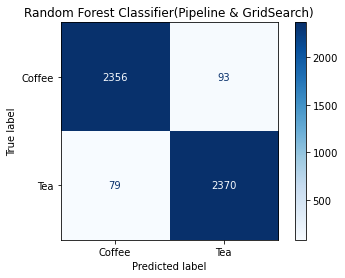

In [101]:
plot_confusion_matrix(gsrf, X_test3, y_test3, cmap='Blues', values_format='d');
plt.title('Random Forest Classifier(Pipeline & GridSearch)')
plt.savefig('../images/rfconfusionmatrix.png')

In [102]:
spec= tn/(tn+fp)
print(f'Specificity is : {spec}')

Specificity is : 0.9620253164556962


Among posts in the coffee subreddit, 96.1% are correctly predicted via this model.

In [103]:
recall=tp/(tp+fn)
print(f'Sensitivity(recall) is : {recall}')

Sensitivity(recall) is : 0.967741935483871


The model correctly predicted 96.8% of the posts in the tea subreddit.

In [104]:
precision=tp/(tp+fp)
print(f'Precision is: {precision}')

Precision is: 0.9622411693057247


In [105]:
f1=2*(prec*recall)/(prec+recall)
print(f'F1 is : {f1}')
#https://towardsdatascience.com/the-3-most-important-composite-classification-metrics-b1f2d886dc7b

F1 is : 0.9584320240674428


In [106]:
type_I=1-spec
print(f'Type I error is: {type_I}')

Type I error is: 0.03797468354430378


This model incorrectly predicted 3.8% of the posts in the coffee subreddit.

In [107]:
type_II=1-recall
print(f'Type II error is: {type_II}')

Type II error is: 0.032258064516129004


This model incorrectly predicted 3.2% of the posts in the tea subreddit.

### AdaBoost Classifier

In [108]:
X_train4, X_test4, y_train4, y_test4=train_test_split(X,y,
                                                   random_state=42,
                                                   stratify=y)

pipeabc= Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('abc', AdaBoostClassifier(random_state=42)),
])
pipeabc.fit(X_train4,y_train4)

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('abc', AdaBoostClassifier(random_state=42))])

In [109]:
pipeabc.score(X_train4,y_train4), pipeabc.score(X_test4, y_test4)

(0.9437185245678508, 0.9393630053082891)

In [110]:
f'Misclassification rate is {1-pipeabc.score(X_test4,y_test4)}'

'Misclassification rate is 0.06063699469171091'

In [111]:
abcpreds=pipeabc.predict(X_test4)

In [112]:
tn,fp,fn,tp= confusion_matrix(y_test4,abcpreds).ravel()

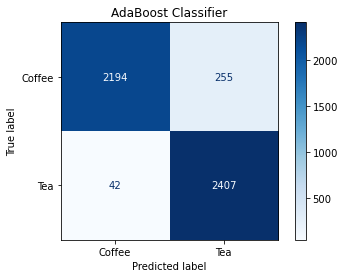

In [113]:
plot_confusion_matrix(pipeabc, X_test4, y_test4, cmap='Blues', values_format='d');
plt.title('AdaBoost Classifier')
plt.savefig('../images/adaconfu_matr.png')

In [114]:
spec= tn/(tn+fp)
print(f'Specificity is : {spec}')

Specificity is : 0.8958758677011025


Among posts in the coffee subreddit 89.6% are correctly predicted via this model.

In [115]:
recall=tp/(tp+fn)
print(f'Sensitivity(recall) is : {recall}')

Sensitivity(recall) is : 0.9828501429154757


The model correctly predicted 98.3% of the posts in the tea subreddit.

In [116]:
precision=tp/(tp+fp)
print(f'Precision is: {precision}')

Precision is: 0.9042073628850489


In [117]:
f1=2*(prec*recall)/(prec+recall)
print(f'F1 is : {f1}')
#https://towardsdatascience.com/the-3-most-important-composite-classification-metrics-b1f2d886dc7b

F1 is : 0.9657835449498239


In [118]:
type_I=1-spec
print(f'Type I error is: {type_I}')

Type I error is: 0.1041241322988975


This model incorrectly predicted 10.4% of the posts in the coffee subreddit.

In [119]:
type_II=1-recall
print(f'Type II error is: {type_II}')

Type II error is: 0.017149857084524323


This model incorrectly predicted 1.7% of the posts in the tea subreddit.